In [1]:
# common imports
import numpy as np
import pandas as pd
import os, cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# global variables
ROWS = 64
COLUMNS = 64
CHANNELS = 3
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
sns.set(style="whitegrid")  # for plots

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples.
* Each sample is a colored image (JPEG file) of a dog or a cat. The image sizes vary, so they need to be scaled to the same size.
* The data contains two labels (mentioned in each image file's name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.


# 1. Getting the Data

In [2]:
train_path = r"dogs-vs-cats\train/"

train_images = [train_path + i for i in os.listdir(train_path)]
# listdir returns a list with the file names in the given directory

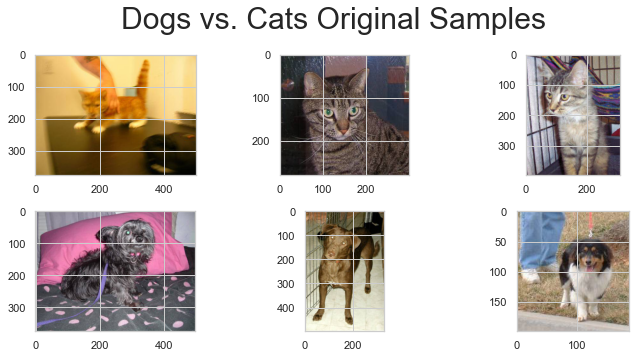

In [3]:
fig = plt.figure(figsize=(10, 7))

for i in range(6):
    plt.subplot(330 + i + 1)
    if i < 3:
        filename = train_path + 'cat.' + str(i) + '.jpg'
    else:
        filename = train_path + 'dog.' + str(i - 3) + '.jpg'
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.suptitle("Dogs vs. Cats Original Samples", size=30)
plt.tight_layout()
plt.show()

> Initial Observations:
>> * There are various image sizes.
>> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
>> * The images are in color, meaning the number of pixels chosen for the width and height will be multiplied by 3.
>> This should be taken into account since it adds a substantial amount of features, as opposing to using grayscale images.
>
> The following functions will read the data, and turn it into a DataFrame.
> When implementing these functions, I took into account that rescaling the images and loading new data could be needed
> further on. (Necessary tweaks implemented in the code according to these measures).
>
> Note: The default rescaled size of the images is 64x64x3. This will likely change later on.

> Why was this necessary?
>
> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
> The following functions do just that:

In [4]:
def read_resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1))
    path = []  # saving the path ensures we can load each image again in case rescaling is required

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y, path

def load_data(img_dir, n_rows, n_cols, n_channels):
    ROWS = n_rows
    COLUMNS = n_cols
    CHANNELS = n_channels
    X, y, path = prep_data(img_dir)
    print("Converting to DataFrame")
    df = pd.concat([pd.DataFrame(path, columns=['path']), pd.DataFrame(y, columns=['label']), pd.DataFrame(X)], axis=1)
    return df


In [5]:
df = load_data(train_images, n_rows=64, n_cols=64, n_channels=3)

Loading: 0/25000
Loading: 5000/25000
Loading: 10000/25000
Loading: 15000/25000
Loading: 20000/25000
Finished Loading Data
Converting to DataFrame


X

labels

path.head()

# create a DataFrame including a column for labels
df = pd.concat([pd.DataFrame(path, columns=['path']), pd.DataFrame(labels, columns=['label']), pd.DataFrame(X)], axis=1)
df.head()

In [13]:
# check if all values are in DataFrame, merely a precaution after this data processing
# np.isnan checks if the element is is not a number
# df.values returns a numpy array containing the data without index or column names
# (like X shown above with an additional value in each row for the label)
# sum() returns the absolute amount missing
# np.isnan(df.values).sum()
df.isna().sum().sum()

0

In [14]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()

In [15]:
# for i in range(11):
# show_images(X, labels, i)

In [16]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [27]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3].drop(['path', 'label'], axis=1)
sample0

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,206,167,90,212,173,96,222,179,101,227,...,0,2,2,0,2,2,0,2,2,0
1,40,44,43,38,41,47,31,35,37,20,...,41,86,69,64,86,70,65,38,25,18
2,42,47,56,41,45,59,41,46,58,52,...,54,172,169,0,193,192,4,180,175,12


In [28]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3].drop(['path', 'label'], axis=1)
sample1

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
12500,115,113,126,146,145,152,160,161,166,163,...,76,70,80,82,68,77,82,83,91,97
12501,137,104,73,160,113,73,137,92,55,134,...,228,244,242,220,244,242,217,234,236,213
12502,141,113,58,132,95,39,120,92,52,132,...,79,99,93,81,97,91,79,99,93,81


In [29]:
df['label'].value_counts()

0.0    12500
1.0    12500
Name: label, dtype: int64

> Observations:
>> * By looking at the index numbers for each group, the first instance labeled 1 (dog) is located at index 12500.
>> My assumption was that all cat images were the first 12,500 samples, with the rest as dogs.
>> To validate my assumptions I counted the values for each class.
>> * Why is this important? Data arranged by class order could result in poor performance of the ML algorithms,
>> an unrepresentative test set or cross-validation folds later on (i.e., a test set containing only cat images).
>> * Solution: The train_test_split() is a random sampling method, so it takes care of this.
>> The random_state parameter ensures that the generated shuffled split is the same each time.
>

In [30]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

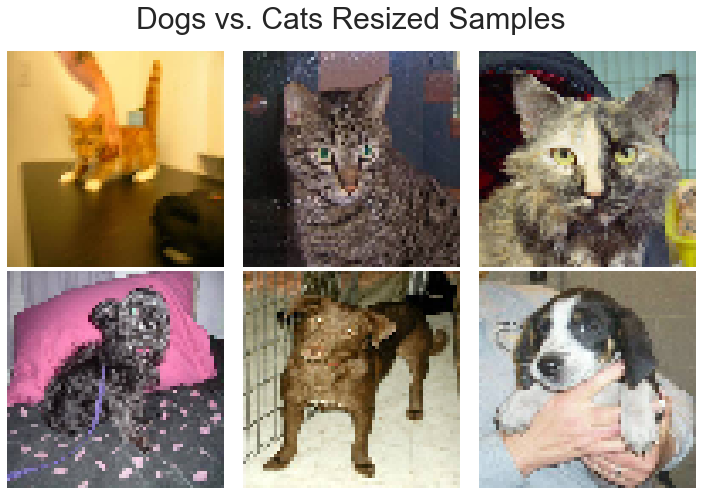

In [33]:
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 3

# add sample image in each iteration
for i in range(rows * columns):
    image = sample_images[i :i + 1].to_numpy().reshape((ROWS, COLUMNS, CHANNELS))
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
fig.suptitle("Dogs vs. Cats Resized Samples", size=30)
plt.tight_layout()
plt.show()

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [34]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [47]:
# deep copy of the training set
df2 = train_set.copy()

In [48]:
df2.head(2)

,path,label,0,1,2,3,4,5,6,7,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
23311,dogs-vs-cats\train/dog.8479.jpg,1.0,21,15,15,21,15,15,16,15,...,49,95,81,72,96,87,78,97,87,83
23623,dogs-vs-cats\train/dog.876.jpg,1.0,168,206,214,203,226,238,149,175,...,210,141,174,203,156,190,218,152,189,216


In [49]:
def image_shape(image_path):
    return cv2.imread(image_path).shape


def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return shapes

In [50]:
image_shapes = load_data_shapes(list(train_set['path']))

In [51]:
image_res_df = pd.DataFrame(image_shapes, columns=['height', 'width', 'n_channels'])
image_res_df.head(3)

,height,width,n_channels
0,377,499,3
1,500,472,3
2,473,452,3


In [52]:
image_res_df.n_channels.unique()

array([3], dtype=int64)

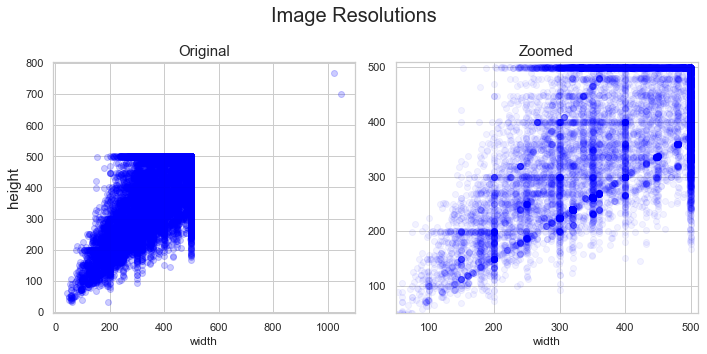

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.2)
ax1.set_title("Original", size=15)
points = ax2.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height", size=15)
ax2.set_xlim(xmin=50, xmax=510)
ax2.set_ylim(ymin=50, ymax=510)
ax2.set_title("Zoomed", size=15)
ax2.set_xlabel("width")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

> Observations:
>> * Most image resolutions are less than 500 by 500. There is also a fair amount around 400x400,
>> 300x300, and 200x200.
>> * Rescaling the images to 200x200 seems to be the best option for maintainable amount of features
>> that also reflects the data.
>> * After rescaling, the number of features will be 200x200x3 = 120,000.
>
> Note: The global variables (instantiated below the imports) have been set to these values.